# Day two: CADD &RDkit

Author: Hazem Ahmed

In [1]:
# The majority of the basic molecular functionality is found in module rdkit.Chem
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
# drawing
from rdkit.Chem import Draw
# fingerprints
from rdkit.Chem import MACCSkeys
import numpy as np
import pandas as pd
# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import random
import numpy as np
# Others
from copy import deepcopy
from itertools import combinations
from matplotlib import pyplot
import statistics

In [2]:
gefitinib = Chem.MolFromSmiles('COc1cc2c(cc1OCCCN3CCOCC3)c(ncn2)Nc4ccc(c(c4)Cl)F')
erlotinib = Chem.MolFromSmiles('COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC')
lapatinib = Chem.MolFromSmiles('CS(=O)(=O)CCNCC1=CC=C(O1)C2=CC3=C(C=C2)'
                               'N=CN=C3NC4=CC(=C(C=C4)OCC5=CC(=CC=C5)F)Cl')
afatinib = Chem.MolFromSmiles('CN(C)CC=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C=C3)F)Cl)OC4CCOC4')

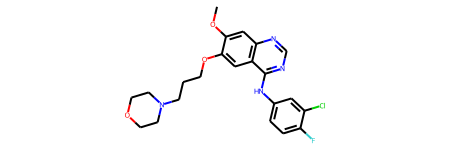

In [3]:
gefitinib

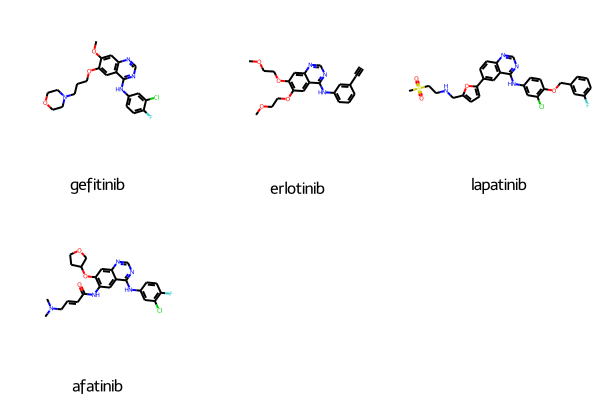

In [4]:
Draw.MolsToGridImage([gefitinib, erlotinib, lapatinib, afatinib],
                     legends=["gefitinib", 'erlotinib', 'lapatinib', 'afatinib'])

## Fingerprinting and Molecular Similarity
### Molecular descriptors in 1D

from rdkit.Chem import AllChem
### Morgan Fingerprints (Circular Fingerprints)
* Applying the Morgan algorithm to a set of user-supplied atom invariants
* When generating Morgan fingerprints, the radius of the fingerprint must also be provided
* Takes a radius parameter -> radius=2 == ECFP4 where 4=diameter

In [5]:
dictionary_of_molecules = {'gefitinib': gefitinib, 'Erlotinib': erlotinib, 'Lapatinib': lapatinib,
                           'afatinib': afatinib}

In [6]:
# This function is to calculate the similarities between
# each of the molecules in a dictionary given as an input
def calculate_similarities(molecules, fingerprint):
    """
    Calculates the similarities between different drug molecules
    using morgan or maccs or either

    Args:
        molecules (dictionary): dictionary of molecules that we need to get their
        similarity, keys as names and the values as the molecule
        fingerprint (string): the type of similarity ['morgan', 'maccs', 'both']
    """

    morgens_dictionary = {}
    maccs_dictionary = {}
    morgen_similarities_dictionary = {}
    maccs_similarities_dictionary = {}
    molecules_names = list(combinations(molecules.keys(), 2))

    if fingerprint == 'morgan':
        for key, value in molecules.items():
            morgens_dictionary[
                key +'_morgen'] = AllChem.GetMorganFingerprint(value,
                                                               radius=2)
        molecules_morgens = list(combinations(morgens_dictionary.values(), 2))
        for fingerprint, name in zip(range(len(molecules_morgens)), molecules_names):
            morgen_similarities_dictionary[
                f'{name[0]}_VS_{name[1]}'] = DataStructs.TanimotoSimilarity(
                molecules_morgens[fingerprint][0],
                molecules_morgens[fingerprint][1])
        similarities_table = pd.DataFrame(
            {'molecules': morgen_similarities_dictionary.keys(),
             'morgen_similarities': morgen_similarities_dictionary.values()})
    elif fingerprint == 'maccs':
        for key, value in molecules.items():
            maccs_dictionary[key+'_MACCS'] = MACCSkeys.GenMACCSKeys(value)
        molecules_maccs = list(combinations(maccs_dictionary.values(), 2))
        for fingerprint, name in zip(range(len(molecules_morgens)), molecules_names):
            maccs_similarities_dictionary[
                f'{name[0]}_VS_{name[1]}'] = DataStructs.TanimotoSimilarity(
                molecules_maccs[fingerprint][0], molecules_maccs[fingerprint][1])
        similarities_table = pd.DataFrame(
            {'molecules': similarities_dictionary.keys(),
             'morgen_similarities': similarities_dictionary.values()})
    elif fingerprint == 'both':
        morgens_dictionary = {}
        maccs_dictionary = {}
        for key, value in molecules.items():
            morgens_dictionary[
                key +'_morgen'] = AllChem.GetMorganFingerprint(value, radius=2)
        for key, value in molecules.items():
            maccs_dictionary[
                key+'_MACCS'] = MACCSkeys.GenMACCSKeys(value)
        molecules_morgens = list(combinations(morgens_dictionary.values(), 2))
        molecules_maccs = list(combinations(maccs_dictionary.values(), 2))
        for fingerprint, name in zip(range(len(molecules_morgens)), molecules_names):
            morgen_similarities_dictionary[
                f'{name[0]}_VS_{name[1]}'] = DataStructs.TanimotoSimilarity(
                molecules_morgens[fingerprint][0],
                molecules_morgens[fingerprint][1])
            maccs_similarities_dictionary[
                f'{name[0]}_VS_{name[1]}'] = DataStructs.TanimotoSimilarity(
                molecules_maccs[fingerprint][0],
                molecules_maccs[fingerprint][1])
        similarities_table = pd.DataFrame(
            {'molecules': morgen_similarities_dictionary.keys(),
             'morgen_similarities': morgen_similarities_dictionary.values(),
             'maccs_similarities': maccs_similarities_dictionary.values()})
    return similarities_table

In [7]:
calculate_similarities(dictionary_of_molecules, fingerprint = 'both')

,molecules,morgen_similarities,maccs_similarities
0,gefitinib_VS_Erlotinib,0.426230,0.692308
1,gefitinib_VS_Lapatinib,0.339869,0.670732
2,gefitinib_VS_afatinib,0.472441,0.780822
3,Erlotinib_VS_Lapatinib,0.309211,0.587500
4,Erlotinib_VS_afatinib,0.311594,0.643836
5,Lapatinib_VS_afatinib,0.316770,0.651685


# Machine learning approach

In [96]:
activities_df = pd.read_csv("https://raw.githubusercontent.com/volkamerlab/CADDCourse2021/main/"
                            "data/CHEMBL25_activities_EGFR.csv?token=AFRFK54FOZDK2YZEX7RJFO3ARLZ2K")
activities_df.head()

,Unnamed: 0,chembl_id,IC50,units,canonical_smiles,pIC50
0,1777,CHEMBL207869,77.0,nM,Fc1cccc(COc2ccc(Nc3ncncc3C#Cc4ncccn4)cc2Cl)c1,7.113509
1,5785,CHEMBL3940060,330.0,nM,Fc1ccc(Nc2ncnc3cc4OC(=O)N(CCOC(=O)CCl)c4cc23)c...,6.481486
2,6373,CHEMBL3678951,1.0,nM,CC(C)n1c(Nc2cccc(c2)C(F)(F)F)nc3cnc(Nc4ccc(cc4...,9.000000
3,2442,CHEMBL504034,40.0,nM,CS(=O)(=O)CCNC(=O)O[C@H]1CN[C@@H](C1)C#Cc2cc3n...,7.397940
4,1084,CHEMBL158797,43000.0,nM,Cn1c(SSc2c(C(=O)NCC(O)CO)c3ccccc3n2C)c(C(=O)NC...,4.366532


## separate actives and inactives

In [9]:
cols = list(activities_df.columns)
cols

['Unnamed: 0', 'chembl_id', 'IC50', 'units', 'canonical_smiles', 'pIC50']

In [10]:
# better way to index the dataframe based on a cutoff
actives_df = deepcopy(activities_df)
inactives_df = deepcopy(activities_df)

In [11]:
actives_df[cols] = actives_df[actives_df['pIC50'] >= 6.3]

In [12]:
actives_df = actives_df.dropna()

In [13]:
actives_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2214 entries, 0 to 3905
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2214 non-null   float64
 1   chembl_id         2214 non-null   object 
 2   IC50              2214 non-null   float64
 3   units             2214 non-null   object 
 4   canonical_smiles  2214 non-null   object 
 5   pIC50             2214 non-null   float64
dtypes: float64(3), object(3)
memory usage: 121.1+ KB


In [14]:
inactives_df[cols] = inactives_df[inactives_df['pIC50'] < 6.3]

In [15]:
inactives_df = inactives_df.dropna()

In [16]:
inactives_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1692 entries, 4 to 3902
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1692 non-null   float64
 1   chembl_id         1692 non-null   object 
 2   IC50              1692 non-null   float64
 3   units             1692 non-null   object 
 4   canonical_smiles  1692 non-null   object 
 5   pIC50             1692 non-null   float64
dtypes: float64(3), object(3)
memory usage: 92.5+ KB


In [17]:
actives_df = actives_df.drop('Unnamed: 0', axis=1)

In [18]:
inactives_df = inactives_df.drop('Unnamed: 0', axis=1)

In [19]:
actives_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2214 entries, 0 to 3905
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chembl_id         2214 non-null   object 
 1   IC50              2214 non-null   float64
 2   units             2214 non-null   object 
 3   canonical_smiles  2214 non-null   object 
 4   pIC50             2214 non-null   float64
dtypes: float64(2), object(3)
memory usage: 103.8+ KB


In [20]:
inactives_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1692 entries, 4 to 3902
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chembl_id         1692 non-null   object 
 1   IC50              1692 non-null   float64
 2   units             1692 non-null   object 
 3   canonical_smiles  1692 non-null   object 
 4   pIC50             1692 non-null   float64
dtypes: float64(2), object(3)
memory usage: 79.3+ KB


##### Get smiles in array


In [21]:
smiles_active = actives_df["canonical_smiles"].tolist()
smiles_inactive = inactives_df["canonical_smiles"].tolist()

In [22]:
fingerprints_active = []
fingerprints_inactive = []

for smile in smiles_active: 
    molecule = Chem.MolFromSmiles(smile)
    fingerprints_active.append(AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=1024))

for smile in smiles_inactive:
    molecule = Chem.MolFromSmiles(smile)
    fingerprints_inactive.append(AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=1024))
    
fps = fingerprints_active + fingerprints_inactive

#### Prepare classifier assignment

In [23]:
# 'Active' = 1
y_active = np.ones(len(fingerprints_active))
y_active

array([1., 1., 1., ..., 1., 1., 1.])

In [24]:
# 'Inactive' = 0
y_inactive = np.zeros(len(fingerprints_inactive))
y_inactive

array([0., 0., 0., ..., 0., 0., 0.])

In [25]:
y = np.concatenate([y_active, y_inactive])

In [26]:
random.seed(1234)
X_train, X_test, y_train, y_test = train_test_split(fps, y, test_size=0.20)

In [27]:
forest = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=100)
forest.fit(X_train, y_train) # Build a forest of trees from the training set

RandomForestClassifier(max_features=100, n_jobs=-1)

##### Test performance of the model

In [28]:
y_pred = forest.predict(X_test) # Predict class for X
y_prob = forest.predict_proba(X_test) # Predict probabilites
accuracy = metrics.accuracy_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_prob[:,1])
print(f"Accuracy: {accuracy:.2f} \t AUC: {roc_auc:.2f}")

Accuracy: 0.87 	 AUC: 0.93


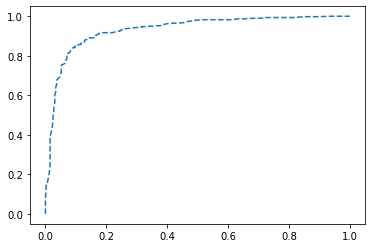

In [29]:
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, y_prob[:,1])
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Morgan')

In [30]:
cm1 = confusion_matrix(y_test,y_pred)
print('Confusion Matrix : \n', cm1)
total1=sum(sum(cm1))
##### from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )
specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[281  44]
 [ 54 403]]
Accuracy :  0.8746803069053708
Sensitivity :  0.8646153846153846
Specificity :  0.8818380743982495


## Cross validation

In [31]:
skf = StratifiedKFold(n_splits=5)
target_df = pd.DataFrame (y,columns=['target'])
target_df.head()

,target
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [32]:
train_df = pd.DataFrame (fps,columns=['molecule'])
train_df['target'] = y
train_df.head()

,molecule,target
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",1.0
2,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",1.0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.0
4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",1.0


In [33]:
fold_no = 1
model = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=100)
accuracies = []
AUCs = []
sensitivities = []
specificities = []
for train_index, test_index in skf.split(train_df, y):
    train = train_df.loc[train_index,:]
    mols = train['molecule'].tolist()
    efficacy = train['target'].tolist()
    test = train_df.loc[test_index,:]
    test_mols = test['molecule'].tolist()
    test_values = test['target'].tolist()
    model.fit(mols, efficacy)
    predictions = model.predict(test_mols)
    print('Fold',str(fold_no),'Accuracy:',metrics.accuracy_score(test_values,predictions))
    accuracies.append(metrics.accuracy_score(test_values,predictions))
    y_prob = model.predict_proba(test_mols) # Predict probabilites
    AUCs.append(metrics.roc_auc_score(test_values, y_prob[:,1]))
    print('AUC : ', metrics.roc_auc_score(test_values, y_prob[:,1]))
    cm1 = confusion_matrix(test_values, predictions)
    total1=sum(sum(cm1))
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivities.append(sensitivity1)
    print('Sensitivity : ', sensitivity1 )
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)
    specificities.append(specificity1)
    fold_no += 1

Fold 1 Accuracy: 0.860613810741688
AUC :  0.9265966159931281
Sensitivity :  0.8525073746312685
Specificity :  0.8668171557562077
Fold 2 Accuracy: 0.8668373879641486
AUC :  0.9214573844283863
Sensitivity :  0.8284023668639053
Specificity :  0.8961625282167043
Fold 3 Accuracy: 0.8540332906530089
AUC :  0.922128574672419
Sensitivity :  0.8136094674556213
Specificity :  0.8848758465011287
Fold 4 Accuracy: 0.8553137003841229
AUC :  0.9166622143267393
Sensitivity :  0.8076923076923077
Specificity :  0.891647855530474
Fold 5 Accuracy: 0.8642765685019206
AUC :  0.9226331104259267
Sensitivity :  0.8141592920353983
Specificity :  0.9027149321266968


In [34]:
def get_average_std(numbers):
    """
    Calculates the average and standard deviation of the list given

    Args:
        numbers (list): list of the values to get the parameters for
    """
    mean = sum(numbers)/len(numbers)
    std = statistics.stdev(numbers)
    return f'The mean is: {mean} and the standard deviation is {std}' 

In [36]:
print(f'folds accuracy: {get_average_std(accuracies)}')
print(f'folds AUC: {get_average_std(AUCs)}')
print(f'folds Sensitivities: {get_average_std(sensitivities)}')
print(f'folds Sensitivities: {get_average_std(specificities)}')

folds accuracy: The mean is: 0.8602149516489778 and the standard deviation is 0.005539577588019762
folds AUC: The mean is: 0.9218955799693198 and the standard deviation is 0.00354535289795933
folds Sensitivities: The mean is: 0.8232741617357003 and the standard deviation is 0.018028869658446602
folds Sensitivities: The mean is: 0.8884436636262423 and the standard deviation is 0.01372909303839862


## Applying the machine learning approach on the test data

In [37]:
test_compounds_df = pd.read_csv("https://raw.githubusercontent.com/volkamerlab/CADDCourse2021/main/"
                                "data/test_compounds_EGFR.csv?token=AFRFK53PLCQU5SA45UDERSDARLZ6U")
test_compounds_df.head()

,Unnamed: 0,chembl_id,canonical_smiles
0,1927,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c4ccccc24)cc1
1,212,CHEMBL107472,CNc1ncc2C=C(C(=O)N(C)c2n1)c3c(Cl)cccc3Cl
2,3089,CHEMBL1077068,CC1=C(C(NC(=N1)Nc2ccc(cc2)S(=O)(=O)Nc3ncccn3)c...
3,3126,CHEMBL1088240,COc1cc(Nc2c(cnc3cc(\C=C\CCN4CCN(C)CC4)c(OC)cc2...
4,3125,CHEMBL1092382,CCC(=O)Nc1ccc2nccc(Nc3cccc(Br)c3)c2c1


In [38]:
test_compounds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1051 non-null   int64 
 1   chembl_id         1051 non-null   object
 2   canonical_smiles  1051 non-null   object
dtypes: int64(1), object(2)
memory usage: 24.8+ KB


In [39]:
smiles_test_compounds = test_compounds_df["canonical_smiles"].tolist()

In [40]:
len(smiles_test_compounds)

1051

In [41]:
test_compounds_df = pd.read_csv("../data/test_compounds_EGFR.csv")
test_compounds_df.head()

,Unnamed: 0,chembl_id,canonical_smiles
0,1927,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c4ccccc24)cc1
1,212,CHEMBL107472,CNc1ncc2C=C(C(=O)N(C)c2n1)c3c(Cl)cccc3Cl
2,3089,CHEMBL1077068,CC1=C(C(NC(=N1)Nc2ccc(cc2)S(=O)(=O)Nc3ncccn3)c...
3,3126,CHEMBL1088240,COc1cc(Nc2c(cnc3cc(\C=C\CCN4CCN(C)CC4)c(OC)cc2...
4,3125,CHEMBL1092382,CCC(=O)Nc1ccc2nccc(Nc3cccc(Br)c3)c2c1


In [42]:
test_compounds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1051 non-null   int64 
 1   chembl_id         1051 non-null   object
 2   canonical_smiles  1051 non-null   object
dtypes: int64(1), object(2)
memory usage: 24.8+ KB


In [43]:
smiles_test_compounds = test_compounds_df["canonical_smiles"].tolist()

In [44]:
len(smiles_test_compounds)

1051

In [45]:
fingerprints_test_compund = []
for smile in smiles_test_compounds:
    molecule = Chem.MolFromSmiles(smile)
    fingerprints_test_compund.append(AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=1024))
test_compounds_fps = fingerprints_test_compund

In [46]:
len(fingerprints_test_compund)

1051

In [47]:
pred_pIC50 = forest.predict(test_compounds_fps)

In [48]:
test_compounds_df['effectiveness'] = pred_pIC50

In [49]:
test_compunds_filtered = deepcopy(test_compounds_df)

In [50]:
test_compunds_filtered.head()

,Unnamed: 0,chembl_id,canonical_smiles,effectiveness
0,1927,CHEMBL101253,Clc1ccc(Nc2nnc(Cc3ccncc3)c4ccccc24)cc1,0.0
1,212,CHEMBL107472,CNc1ncc2C=C(C(=O)N(C)c2n1)c3c(Cl)cccc3Cl,0.0
2,3089,CHEMBL1077068,CC1=C(C(NC(=N1)Nc2ccc(cc2)S(=O)(=O)Nc3ncccn3)c...,0.0
3,3126,CHEMBL1088240,COc1cc(Nc2c(cnc3cc(\C=C\CCN4CCN(C)CC4)c(OC)cc2...,0.0
4,3125,CHEMBL1092382,CCC(=O)Nc1ccc2nccc(Nc3cccc(Br)c3)c2c1,1.0


In [51]:
cols2 = ['Unnamed: 0', 'chembl_id', 'canonical_smiles', 'effectiveness']

In [52]:
test_compunds_filtered[cols2] = test_compunds_filtered[test_compunds_filtered['effectiveness'] > 0.0]
test_compunds_filtered = test_compunds_filtered.dropna()

In [53]:
test_compunds_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 4 to 1047
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        639 non-null    float64
 1   chembl_id         639 non-null    object 
 2   canonical_smiles  639 non-null    object 
 3   effectiveness     639 non-null    float64
dtypes: float64(2), object(2)
memory usage: 25.0+ KB


# Substructure search

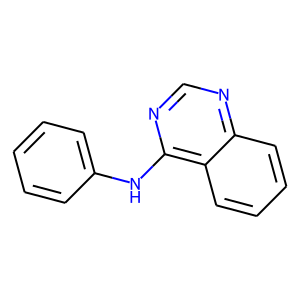

In [54]:
substructure_query = Chem.MolFromSmiles("C12=NC=NC(=C1C=CC=C2)NC3=CC=CC=C3")
Chem.Draw.MolToImage(substructure_query)

In [55]:
ml_filtered_smiles = test_compunds_filtered['canonical_smiles'].tolist()

In [56]:
ml_filtered_mols = []
for smile in ml_filtered_smiles:
    molecule = Chem.MolFromSmiles(smile)
    ml_filtered_mols.append(molecule)

In [57]:
len(ml_filtered_mols)

639

In [58]:
submolecules = [molecule for molecule in ml_filtered_mols if molecule.HasSubstructMatch(substructure_query)]
print(len(submolecules), "matches out of", len(ml_filtered_mols))

307 matches out of 639


In [59]:
test_compunds_filtered['mols'] = ml_filtered_mols
test_compunds_filtered.head()

,Unnamed: 0,chembl_id,canonical_smiles,effectiveness,mols
4,3125.0,CHEMBL1092382,CCC(=O)Nc1ccc2nccc(Nc3cccc(Br)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
12,3152.0,CHEMBL1097368,C(Cc1cc2c(Nc3ccc4[nH]ccc4c3)ncnc2[nH]1)c5ccccc5,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
14,128.0,CHEMBL113023,COc1ccc(Nc2ncc3C=C(C(=O)N(C)c3n2)c4c(Cl)cccc4C...,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
15,217.0,CHEMBL113070,CN1C(=O)C(=Cc2cnc(Nc3ccc(CCCC(=O)O)cc3)nc12)c4...,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
21,1121.0,CHEMBL116748,[O-][N+](=O)c1ccc2c(NCc3ccccc3)ncnc2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [60]:
substruct_ml_filtered_mols = pd.DataFrame()
for i in range(306):
    substruct_ml_filtered_mols = substruct_ml_filtered_mols.append(
        test_compunds_filtered[
            test_compunds_filtered['mols'] == submolecules[i]])

In [61]:
substruct_ml_filtered_mols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 48 to 1046
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        306 non-null    float64
 1   chembl_id         306 non-null    object 
 2   canonical_smiles  306 non-null    object 
 3   effectiveness     306 non-null    float64
 4   mols              306 non-null    object 
dtypes: float64(2), object(3)
memory usage: 14.3+ KB


In [62]:
substruct_ml_filtered_mols

,Unnamed: 0,chembl_id,canonical_smiles,effectiveness,mols
48,441.0,CHEMBL1202478,Cl.COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OC\C=C\CN4C...,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
49,1909.0,CHEMBL1204168,Cl.COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
97,26.0,CHEMBL133024,C\N=N\Nc1ccc2ncnc(Nc3cccc(Cl)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
100,163.0,CHEMBL136178,CC(=O)\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
102,23.0,CHEMBL136491,CN(C)\N=N\c1ccc2ncnc(Nc3cccc(Cl)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...,...,...,...
1040,1237.0,CHEMBL92174,COc1cc2ncnc(Nc3ccccc3Br)c2cc1OC,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
1041,1308.0,CHEMBL92731,CCCN(CCC)C\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)...,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
1043,151.0,CHEMBL93464,C\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
1044,1317.0,CHEMBL93754,Brc1cccc(Nc2ncnc3ccc(NC(=O)\C=C\Cn4cccn4)cc23)c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [63]:
# trial = substruct_ml_filtered_mols[substruct_ml_filtered_mols['chembl_id'] == 'CHEMBL1221700']

In [64]:
# trial.info()

# Descriptors separation
Function by Ahmed who did the presentation at day 3

In [65]:
def descriptors(smile):
    """ 
    function to calculate some of descriptors to molecules
    input : smile of the molecule 
    output:  data frame of one vector with the smile or the name of compound and descriptors 
    Mol Weight , number of Hydrogen  acceptor and donor and logP"
    """
    # get the info about the molecule related to the smile if present from the dataframe
    compound = smile
    descriptorlist = ['MOLWT', 'HB acceptor', 'HB donor', 'logp']

    for descript in descriptorlist:
        if descript == "MOLWT":
            # calculate the molecular weight
            MOLWT = Descriptors.ExactMolWt(Chem.MolFromSmiles(smile))

        elif descript == 'HB acceptor':
            # calculate the number of hydrogen bond acceptor
            HB_acceptor = Descriptors.NumHAcceptors(Chem.MolFromSmiles(smile))

        elif descript == 'HB donor':
            # calculate the number of hydrogen bond donor
            HB_donor = Descriptors.NumHDonors(Chem.MolFromSmiles(smile))

        elif descript == 'logp':
            # calculate the logp
            logp = Descriptors.MolLogP(Chem.MolFromSmiles(smile))

    # checking if the name compound present to add to the dataframe
    if len(compound) != 0:
        comp_desc = {'MOLWT': MOLWT, 'HB_acceptor': HB_acceptor,
                     'HB_donor': HB_donor, 'logp': logp}
    # if the name of compound not present , add the smile as it is
    else:
        comp_desc = {'smiles': smile, 'MOLWT': MOLWT, 'HB_acceptor': HB_acceptor,
                     'HB_donor': HB_donor, 'logp': logp}

    df_comp_desc = pd.DataFrame.from_dict(
        comp_desc, orient='index').transpose()

    return df_comp_desc

In [66]:
def checkLipinskis_rule(smile):
    """ 
    check the Lipinskis rules to molcules 
    No more than 5 hydrogen bond donors
    No more than 10 hydrogen bond acceptors
    A molecular mass < 500 Daltons
    An octanol-water partition coefficient logP < 5

    input : smile of the molcule 
    output : the name of molecule and how nmany fulfil the rule

    """
    violatescore = 0
    # calculate the descriptors
    descriptor = descriptors(smile)
    # compound = antiEGFR.loc[antiEGFR.Smiles == smile].iloc[0,0]

    # violaterule to add the missing properites of the rule
    violaterule = []

    # checking that Mol weight not more 500 Dalt
    if descriptor['MOLWT'][0] > 500:
        violatescore += 1
        violaterule.append('MOLWT')

    # checking that number of hydrogen acceptors not more 10
    if descriptor['HB_acceptor'][0] > 10:
        violatescore += 1
        violaterule.append('HB_acceptor')

    # checking that  number of hydrogen donor groups not more 5
    if descriptor['HB_donor'][0] > 5:
        violatescore += 1
        violaterule.append('HB_donor')

    # checking that logp not more 5
    if descriptor['logp'][0] > 5:
        violatescore += 1
        violaterule.append('logp')

    # add Nothing if there is no missing part in the rule
    return violatescore

In [67]:
substruct_ml_filtered_smiles = substruct_ml_filtered_mols['canonical_smiles'].tolist()

In [68]:
descriptor_allmolecules = pd.DataFrame()
for smile in substruct_ml_filtered_smiles:
    descript_onemolc = descriptors(smile)
    descriptor_allmolecules = descriptor_allmolecules.append(descript_onemolc, ignore_index = True)
descriptor_allmolecules

,MOLWT,HB_acceptor,HB_donor,logp
0,522.083344,6.0,1.0,5.7362
1,395.003617,5.0,1.0,4.5749
2,312.089022,5.0,2.0,4.4357
3,410.037838,5.0,2.0,4.2196
4,326.104672,5.0,1.0,4.5871
...,...,...,...,...
301,359.026939,5.0,1.0,4.1531
302,481.147723,5.0,2.0,5.7526
303,382.042923,4.0,2.0,4.6505
304,448.064721,6.0,2.0,4.5273


In [69]:
checklipinskisfor_molecules = [checkLipinskis_rule(smile) for smile in substruct_ml_filtered_smiles]

In [70]:
data_filtered_ML_struc_lip = deepcopy(substruct_ml_filtered_mols)

In [71]:
data_filtered_ML_struc_lip['lip_rule_check'] = checklipinskisfor_molecules

In [72]:
col_names_final = ['Unnamed: 0', 'chembl_id',
                   'canonical_smiles', 'effectiveness', 'mols', 'lip_rule_check']

In [73]:
data_filtered_ML_struc_lip[col_names_final] = data_filtered_ML_struc_lip[
    data_filtered_ML_struc_lip['lip_rule_check'] < 1]

In [74]:
data_filtered_ML_struc_lip = data_filtered_ML_struc_lip.dropna()
data_filtered_ML_struc_lip.head()

,Unnamed: 0,chembl_id,canonical_smiles,effectiveness,mols,lip_rule_check
49,1909.0,CHEMBL1204168,Cl.COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0
97,26.0,CHEMBL133024,C\N=N\Nc1ccc2ncnc(Nc3cccc(Cl)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0
100,163.0,CHEMBL136178,CC(=O)\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0
102,23.0,CHEMBL136491,CN(C)\N=N\c1ccc2ncnc(Nc3cccc(Cl)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0
104,77.0,CHEMBL137189,C\N=N\Nc1ccc2ncnc(Nc3cccc(C)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0


In [75]:
data_filtered_ML_struc_lip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 49 to 1046
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        148 non-null    float64
 1   chembl_id         148 non-null    object 
 2   canonical_smiles  148 non-null    object 
 3   effectiveness     148 non-null    float64
 4   mols              148 non-null    object 
 5   lip_rule_check    148 non-null    float64
dtypes: float64(3), object(3)
memory usage: 8.1+ KB


## Similarity search to identify the most similar compounds to the active ones

In [76]:
def get_avg_similarities(smiles, active_drugs):
    """
    Gets the average similarities based on the set of active drugs.

    Args:
        smiles (list): list of the molecules in the form of smiles.
        fingerprint (list): list of the active drugs in molecule form.
    """
    average_similarities = []
    for smile in smiles:
        similarity = 0
        molecule = Chem.MolFromSmiles(smile)
        molecule_morgan = AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=1024)
        for drug in active_drugs:
            drug_morgan = AllChem.GetMorganFingerprintAsBitVect(drug, radius=2, nBits=1024)
            similarity += DataStructs.TanimotoSimilarity(molecule_morgan, drug_morgan)
        average = similarity/4
        average_similarities.append(average)
    return average_similarities

In [77]:
egfr_drugs = [gefitinib, lapatinib, erlotinib, afatinib]
data_filtered_ML_struc_lip_smiles = data_filtered_ML_struc_lip[
    'canonical_smiles'].tolist()

In [78]:
data_average_similarities = get_avg_similarities(
    smiles=data_filtered_ML_struc_lip_smiles, active_drugs=egfr_drugs)

In [79]:
len(data_average_similarities)

148

In [80]:
data_filtered_ML_struc_lip['similarities'] = data_average_similarities
data_filtered_ML_struc_lip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 49 to 1046
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        148 non-null    float64
 1   chembl_id         148 non-null    object 
 2   canonical_smiles  148 non-null    object 
 3   effectiveness     148 non-null    float64
 4   mols              148 non-null    object 
 5   lip_rule_check    148 non-null    float64
 6   similarities      148 non-null    float64
dtypes: float64(4), object(3)
memory usage: 9.2+ KB


In [81]:
data_filtered_ML_struc_lip.head()

,Unnamed: 0,chembl_id,canonical_smiles,effectiveness,mols,lip_rule_check,similarities
49,1909.0,CHEMBL1204168,Cl.COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.379969
97,26.0,CHEMBL133024,C\N=N\Nc1ccc2ncnc(Nc3cccc(Cl)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.322011
100,163.0,CHEMBL136178,CC(=O)\C=C\C(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.306538
102,23.0,CHEMBL136491,CN(C)\N=N\c1ccc2ncnc(Nc3cccc(Cl)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.318873
104,77.0,CHEMBL137189,C\N=N\Nc1ccc2ncnc(Nc3cccc(C)c3)c2c1,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.299309


In [82]:
data_filtered_ML_struc_lip.sort_values(by=['similarities'], inplace=True, ascending=False)
data_filtered_ML_struc_lip.head()

,Unnamed: 0,chembl_id,canonical_smiles,effectiveness,mols,lip_rule_check,similarities
310,4425.0,CHEMBL2334001,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCO,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.488878
309,4426.0,CHEMBL2333999,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCBr,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.481062
968,684.0,CHEMBL56912,COCCNCCOc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.480063
588,5265.0,CHEMBL3622639,COCCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)\C=...,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.479661
739,5793.0,CHEMBL3918330,C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC...,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.478080


In [83]:
egfr_hits = data_filtered_ML_struc_lip[:20]
egfr_hits.head()

,Unnamed: 0,chembl_id,canonical_smiles,effectiveness,mols,lip_rule_check,similarities
310,4425.0,CHEMBL2334001,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCO,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.488878
309,4426.0,CHEMBL2333999,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCBr,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.481062
968,684.0,CHEMBL56912,COCCNCCOc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.480063
588,5265.0,CHEMBL3622639,COCCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)\C=...,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.479661
739,5793.0,CHEMBL3918330,C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC...,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.478080


In [84]:
egfr_hits

,Unnamed: 0,chembl_id,canonical_smiles,effectiveness,mols,lip_rule_check,similarities
310,4425.0,CHEMBL2334001,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCO,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.488878
309,4426.0,CHEMBL2333999,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCBr,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.481062
968,684.0,CHEMBL56912,COCCNCCOc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.480063
588,5265.0,CHEMBL3622639,COCCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)\C=...,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.479661
739,5793.0,CHEMBL3918330,C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC...,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.478080
996,3021.0,CHEMBL597949,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCC#C,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.471829
994,2951.0,CHEMBL597752,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCC(=O)NO,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.468604
954,661.0,CHEMBL55794,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCNC(C)C,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.463524
972,719.0,CHEMBL57892,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCNC(C)(C)C,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.463172
334,4542.0,CHEMBL2425088,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCN4CC5(CCO...,1.0,"<img data-content=""rdkit/molecule"" src=""data:i...",0.0,0.462053


In [85]:
del egfr_hits['Unnamed: 0']
egfr_hits.drop(['effectiveness', 'mols', 'lip_rule_check', 'similarities'], inplace=True, axis=1)
egfr_hits.head()

/Users/hazemahmed/opt/anaconda3/envs/cadd-course/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,chembl_id,canonical_smiles
310,CHEMBL2334001,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCO
309,CHEMBL2333999,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCBr
968,CHEMBL56912,COCCNCCOc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC
588,CHEMBL3622639,COCCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)\C=...
739,CHEMBL3918330,C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC...


In [86]:
hits_smiles = egfr_hits['canonical_smiles'].tolist()

In [87]:
hits_descriptors = pd.DataFrame()
for i in range(20):
    descript_onemolc = descriptors(egfr_hits.iloc[i, 1])    
    hits_descriptors = hits_descriptors.append(descript_onemolc, ignore_index = True)
hits_descriptors['canonical_smiles'] = hits_smiles
hits_descriptors

,MOLWT,HB_acceptor,HB_donor,logp,canonical_smiles
0,363.078597,6.0,2.0,3.5456,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCO
1,424.994195,5.0,1.0,4.9482,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCBr
2,420.136446,7.0,2.0,3.7893,COCCNCCOc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC
3,473.162996,7.0,2.0,4.2474,COCCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)\C=...
4,499.178646,7.0,2.0,4.7816,C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC...
5,357.068033,5.0,1.0,4.1865,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCC#C
6,420.100061,7.0,3.0,3.8389,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCC(=O)NO
7,404.141532,6.0,2.0,4.5513,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCNC(C)C
8,418.157182,6.0,2.0,4.9414,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCNC(C)(C)C
9,444.136446,7.0,1.0,4.0280,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCN4CC5(CCO...


In [88]:
col_names = ['MW', 'HA', 'HD', 'logp', 'canonical_smiles']
hits_descriptors.columns = col_names
hits_descriptors.head()

,MW,HA,HD,logp,canonical_smiles
0,363.078597,6.0,2.0,3.5456,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCO
1,424.994195,5.0,1.0,4.9482,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCBr
2,420.136446,7.0,2.0,3.7893,COCCNCCOc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC
3,473.162996,7.0,2.0,4.2474,COCCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)\C=...
4,499.178646,7.0,2.0,4.7816,C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC...


In [89]:
egfr_hits_descriptors = pd.merge(egfr_hits,
                                 hits_descriptors[['MW', 'HA', 'HD', 'logp', 'canonical_smiles']],
                                 on='canonical_smiles')
egfr_hits_descriptors.head()

,chembl_id,canonical_smiles,MW,HA,HD,logp
0,CHEMBL2334001,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCO,363.078597,6.0,2.0,3.5456
1,CHEMBL2333999,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCBr,424.994195,5.0,1.0,4.9482
2,CHEMBL56912,COCCNCCOc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC,420.136446,7.0,2.0,3.7893
3,CHEMBL3622639,COCCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)\C=...,473.162996,7.0,2.0,4.2474
4,CHEMBL3918330,C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC...,499.178646,7.0,2.0,4.7816


In [90]:
egfr_hits_descriptors.rename(columns={'canonical_smiles':'smiles'}, inplace=True)
egfr_hits_descriptors.head()

,chembl_id,smiles,MW,HA,HD,logp
0,CHEMBL2334001,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCO,363.078597,6.0,2.0,3.5456
1,CHEMBL2333999,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCBr,424.994195,5.0,1.0,4.9482
2,CHEMBL56912,COCCNCCOc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC,420.136446,7.0,2.0,3.7893
3,CHEMBL3622639,COCCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)\C=...,473.162996,7.0,2.0,4.2474
4,CHEMBL3918330,C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC...,499.178646,7.0,2.0,4.7816


,chembl_id,smiles,MW,HA,HD,logp,ROMol
0,CHEMBL2334001,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCO,363.078597,6.0,2.0,3.5456,
1,CHEMBL2333999,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCBr,424.994195,5.0,1.0,4.9482,
2,CHEMBL56912,COCCNCCOc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC,420.136446,7.0,2.0,3.7893,
3,CHEMBL3622639,COCCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)\C=...,473.162996,7.0,2.0,4.2474,
4,CHEMBL3918330,C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC...,499.178646,7.0,2.0,4.7816,
5,CHEMBL597949,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCC#C,357.068033,5.0,1.0,4.1865,
6,CHEMBL597752,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCC(=O)NO,420.100061,7.0,3.0,3.8389,
7,CHEMBL55794,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCNC(C)C,404.141532,6.0,2.0,4.5513,
8,CHEMBL57892,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCNC(C)(C)C,418.157182,6.0,2.0,4.9414,
9,CHEMBL2425088,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCN4CC5(CCO...,444.136446,7.0,1.0,4.0280,

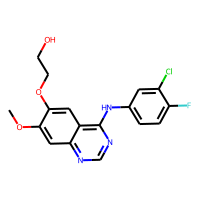
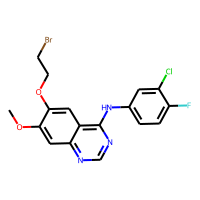
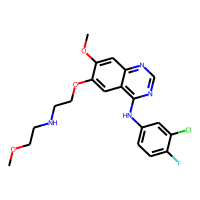
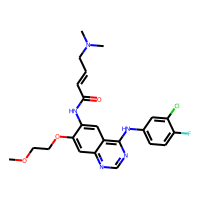
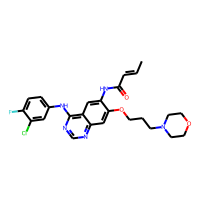
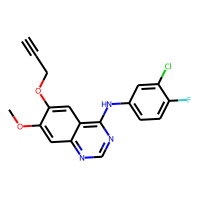
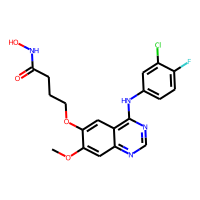
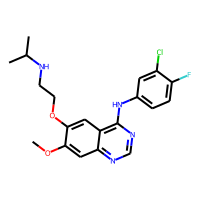
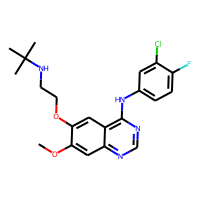
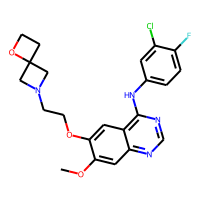
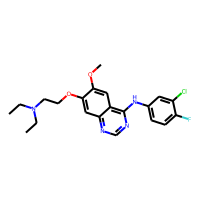
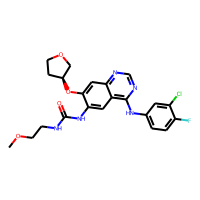
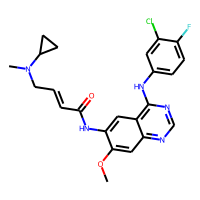
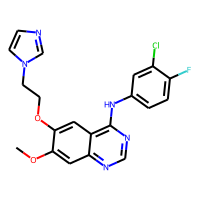
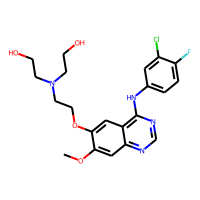
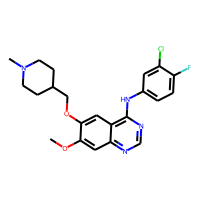
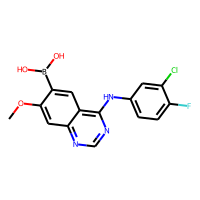
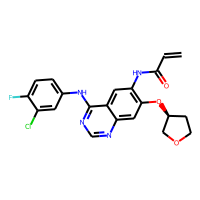
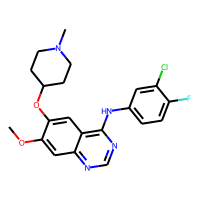
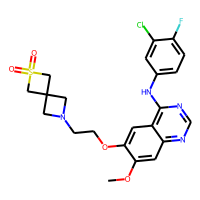

In [95]:
PandasTools.AddMoleculeColumnToFrame(egfr_hits_descriptors, smilesCol='smiles')
egfr_hits_descriptors

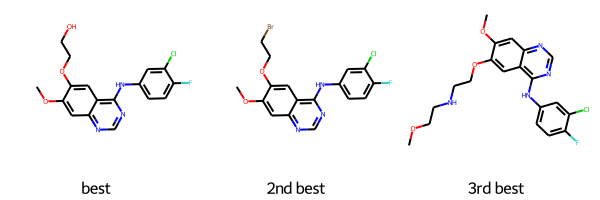

In [92]:
best_hits_list = []
for i in range(3):
    best_hits_list.append(Chem.MolFromSmiles(egfr_hits.iloc[i,1]))

Draw.MolsToGridImage(best_hits_list,
                     legends=['best', '2nd best', '3rd best'])

In [93]:
# mols = egfr_hits_descriptors['smiles'].tolist()
# w = Chem.SDWriter('../data/my_best_mols.sdf')
# for m in mols:
#     m2 = Chem.MolFromSmiles(m)
#     w.write(m2)